In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D 
from sklearn import datasets
from sklearn import model_selection

# Урок 4. Алгоритм построения дерева решений.

**1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).**

In [2]:
# Сгенерируем данные

classification_data, classification_labels = datasets.make_classification(
    n_features = 2,
    n_informative = 2,
    n_classes = 2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=5
)

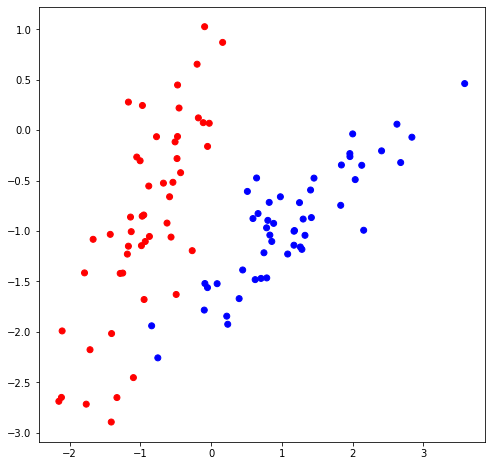

In [3]:
# Визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:,0], classification_data[:,1], c=classification_labels, cmap=colors)
plt.show()

In [4]:
# Класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# Класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения по произвольному критерию

def find_best_split(data, labels, stop_rule, deep):
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            current_quality = quality(true_labels, false_labels, current_gini)

            if stop_rule:
                if (stop_rule( \
                    deep=deep, \
                    current_quality=current_quality, \
                    best_quality=best_quality, \
                    true_labels=true_labels, \
                    false_labels=false_labels) \
                ):
                    continue
                        
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, stop_rule=None, _deep=1):

    quality, t, index = find_best_split(data, labels, stop_rule=stop_rule, deep=_deep)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, stop_rule=stop_rule, _deep=_deep+1)
    false_branch = build_tree(false_data, false_labels, stop_rule=stop_rule, _deep=_deep+1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Метод для печати дерева

def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [14]:
# Метод для получения информации о дереве: глубина, количество листьев и количество узлов

def get_info(node):
    if isinstance(node, Leaf):
        return 0, 1, 0

    l_deep, l_leafs, l_nodes =  get_info(node.true_branch)    
    r_deep, r_leafs, r_nodes =  get_info(node.false_branch)

    deep = max(l_deep, r_deep) + 1
    leafs = l_leafs + r_leafs
    nodes = l_nodes + r_nodes + 1

    return deep, leafs, nodes

In [15]:
# Реализуем различные критерии остановки обучения дерева

# Проверка на максимальную глубину дерева
max_deep_criterion = lambda deep: lambda **kwargs: kwargs["deep"] > deep

# Проверка на минимальное приращеине критерия качества 
min_quality_diff_criterion = lambda min_quality: lambda **kwargs: kwargs["current_quality"] - kwargs["best_quality"] < min_quality

# Вспомогательная функция для определения идентичности всех элементов массива
is_same_labels = lambda labels: np.unique(labels).size == 1

# Проверка что все значения в узле принадлежат одному классу
same_classes_at_leaf_criterion = lambda **kwargs: is_same_labels(kwargs["true_labels"]) - is_same_labels(kwargs["false_labels"])

# Проверка на минимальное число элементов выборки в узле
min_obj_at_leaf_criterion = lambda min_leaf: lambda **kwargs: len(kwargs["true_labels"]) < min_leaf and len(kwargs["false_labels"]) < min_leaf


In [16]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [17]:
# Методы для визуализации данных и дерева на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def draw_dataset(train_data, train_labels, test_data, test_labels, tree):
    plt.figure(figsize = (10, 4))

    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], tree)).reshape(xx.shape)

    # график обучающей выборки
    plt.subplot(1,2,1)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title('Обучающая выборка')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title('Тестовая выборка')

    plt.show()

Все подготовительные работы сделаны. Теперь разобьём исходную выборку на тренировочную и тестовую. Далее в цикле будем строить деревья с различными критериями остановки и посмотрим на результат.

In [18]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, 
    classification_labels,
    test_size = 0.3,
    random_state = 1
)


Критерий остановки: нет критерия
Глубина: 	5
Узлов: 		5
Листьев: 	6
Точность обучающей выборки: 	100.0
Точность тестовой выборки: 	96.66666666666667


C:\Users\amfet\AppData\Local\Temp/ipykernel_12388/710395985.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
C:\Users\amfet\AppData\Local\Temp/ipykernel_12388/710395985.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


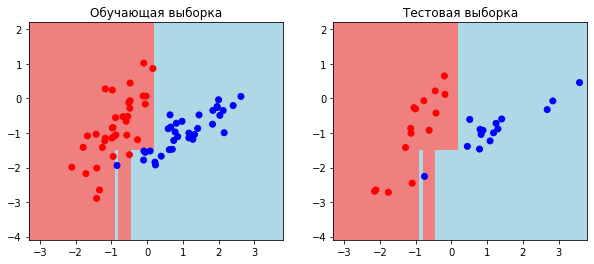


Критерий остановки: глубина дерева больше 3
Глубина: 	3
Узлов: 		3
Листьев: 	4
Точность обучающей выборки: 	98.57142857142858
Точность тестовой выборки: 	100.0


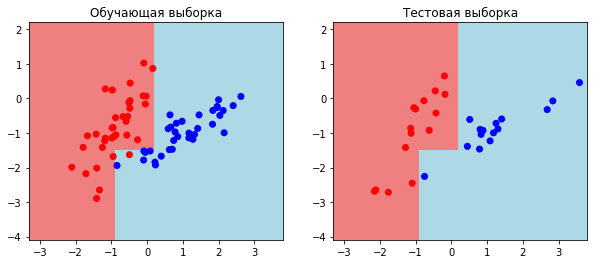


Критерий остановки: приращение функционала качества меньше 0.01
Глубина: 	3
Узлов: 		4
Листьев: 	5
Точность обучающей выборки: 	98.57142857142858
Точность тестовой выборки: 	93.33333333333333


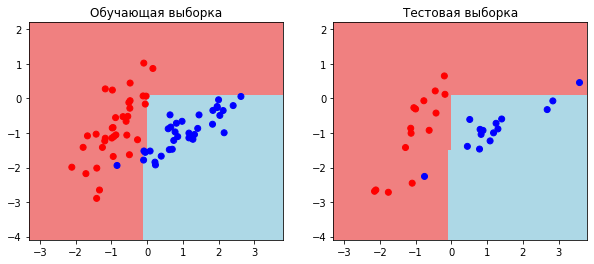


Критерий остановки: в листе все элементы одного класса
Глубина: 	3
Узлов: 		4
Листьев: 	5
Точность обучающей выборки: 	98.57142857142858
Точность тестовой выборки: 	93.33333333333333


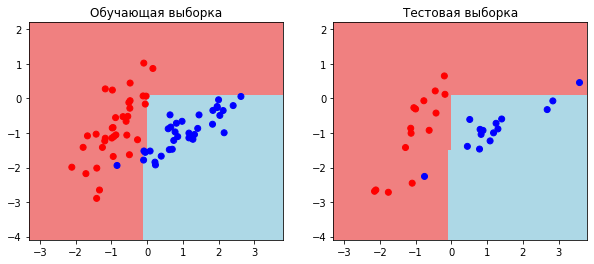


Критерий остановки: минимум 5 элементов в листе
Глубина: 	4
Узлов: 		4
Листьев: 	5
Точность обучающей выборки: 	98.57142857142858
Точность тестовой выборки: 	100.0


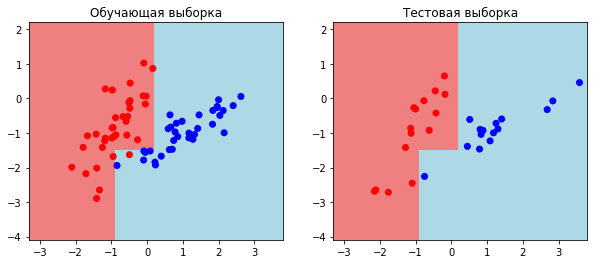

In [19]:
# Критерии остановки
criterions = [
    (None, 'нет критерия'),
    (max_deep_criterion(3), 'глубина дерева больше 3'),
    (min_quality_diff_criterion(0.01), 'приращение функционала качества меньше 0.01'),
    (same_classes_at_leaf_criterion, 'в листе все элементы одного класса'),
    (min_obj_at_leaf_criterion(5), 'минимум 5 элементов в листе'),
]

for stop_rule, criterion_label in criterions:
    print(f'\nКритерий остановки: {criterion_label}')

    # обучение
    my_tree = build_tree(train_data, train_labels, stop_rule=stop_rule)

    # размеры дерева
    deep, leafs, nodes = get_info(my_tree)
    print(f'Глубина: \t{deep}\nУзлов: \t\t{nodes}\nЛистьев: \t{leafs}')

    # предсказание
    train_answers = predict(train_data, my_tree)
    test_answers = predict(test_data, my_tree)

    # параметры точности
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность обучающей выборки: \t{train_accuracy}\nТочность тестовой выборки: \t{test_accuracy}')

    draw_dataset(train_data, train_labels, test_data, test_labels, my_tree)


**2*.  Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [20]:
# Сгенерируем набор данных

regression_data, regression_labels, coef = datasets.make_regression(
    n_samples=1000, 
    n_features = 2, 
    n_informative = 2, 
    n_targets = 1,
    noise = 5,
    coef = True,
    random_state = 2
)

Переопределим класс узла, критерий Джини и метрику точности для модели регрессии.

In [22]:
# Класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction

In [23]:
# Расчет критерия информативности
def gini(labels):
    return np.inf if len(labels) == 0 else np.var(labels, ddof=1)

# Метрика точности mse
def accuracy_metric(actual, predicted): 
    return np.mean((actual - predicted) ** 2)

In [24]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    regression_data, 
    regression_labels,
    test_size = 0.3,
    random_state = 1
)

In [28]:
# обучение
my_tree = build_tree(train_data, train_labels, stop_rule=min_quality_diff_criterion(1))

# размеры дерева
deep, leafs, nodes = get_info(my_tree)
print(f'Глубина: \t{deep}\nУзлов: \t\t{nodes}\nЛистьев: \t{leafs}')

# предсказание
train_answers = predict(train_data, my_tree)
test_answers = predict(test_data, my_tree)

# параметры точности
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'MSE обучающей выборки: \t{train_accuracy}\nMSE тестовой выборки: \t{test_accuracy}')

Глубина: 	13
Узлов: 		266
Листьев: 	267
MSE обучающей выборки: 	31.553959292975467
MSE тестовой выборки: 	196.30878490732186


In [29]:
np.array([train_labels, train_answers]).T[0:10]

array([[-107.12035767, -114.1813633 ],
       [ -16.51317363,   -9.60792053],
       [  76.71792363,   73.73809918],
       [  76.54746336,   75.01176153],
       [ 117.15494548,  115.39834652],
       [ -83.3637331 ,  -87.90852884],
       [-107.77070468, -113.36070254],
       [  48.78128877,   48.88609292],
       [ -49.07059313,  -42.84789969],
       [-146.18505082, -148.44393791]])

In [30]:
np.array([test_labels, test_answers]).T[0:10]

array([[  68.91141589,   53.86811827],
       [ -47.05966568,  -53.51831911],
       [ -23.09151583,  -24.23867465],
       [ -50.40253848,  -26.30130415],
       [ -82.9488116 ,  -84.46701849],
       [ -28.37183067,  -42.84789969],
       [-137.78121349, -128.99978947],
       [  -3.88065649,   -2.1020414 ],
       [ -52.40771231,  -42.25974988],
       [   3.38914896,    3.04816553]])

На маленьком объёме данных модель быстро переобучается и метрика качества на тестовой выборке получается очень большой.